In [2]:
"""
This script explores a single dataset and produces results only for it
"""

'\nThis script explores a single dataset and produces results only for it\n'

In [16]:
"""
NOTE: to run notebook use: venv/bin/python manage.py shell_plus --notebook
"""

MYPROJECT='/Users/erotundo/PycharmProjects/DatasetAnnotatorProj'
import os, sys
sys.path.insert(0, MYPROJECT)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")

import django
django.setup()

from django.conf import settings
from DatasetAnnotator.models import Posts
from django.db.models import Q, F
from django.db.models import Count, Sum, Max, Avg
from django.db.models import When, Case, Value
from django.db.models import IntegerField, FloatField
import numpy as np
import pandas as pd
from django.db.models.functions import Greatest, Coalesce

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# community selection
#available_dbs = settings.DATABASES.keys()[1:]
db = 'travel'


# plotting settings
sns.set(style="white", palette="muted", color_codes=True)
PLOTS_PATH = 'AnalysisBestAnswer/plots/' + db + '/'
PLOTS_FORMATS = ['.pdf', '.png']

# Threads length (all data)

In [13]:
# example: {'cooking':[1,2,1,2,5], 'webapps': [...] ....}
threads_length = dict()


os.write(1, db+"\n")

    
# STAGE 1: considering (only) actual threads (later must sum 1 for the question)
threads_length[db] = Posts.objects\
    .using(db)\
    .filter(posttypeid=2)\
    .values('parentid')\
    .annotate(thread_len_part=Count('parentid'))\
    .values_list('thread_len_part', flat=True)
# adding 1 to count the question
threads_length[db] = [x+1 for x in threads_length[db]]


# STAGE 2: considering (only) unanswered questions
# get ids of questions with answers
parent_questions_ids = Posts.objects\
    .using(db)\
    .filter(posttypeid=2)\
    .values_list('parentid', flat=True)\
    .distinct()
# count unanswered questions
unanswered_q_count = Posts.objects\
    .using(db)\
    .filter(posttypeid=1)\
    .exclude(id__in=parent_questions_ids)\
    .count()

# append unanswered q to total counting
threads_length[db] = threads_length[db] + [1 for i in range(unanswered_q_count)]

# Thread length VS Nr threads (all data)

In [14]:
# for each distinct value in [...] count its occurence, zip the result

t_length_count = dict()

# count occurences
bins = np.bincount(threads_length[db])
# remove zeros from bins
t_count = bins[np.nonzero(bins)]
# sorted threads sizes
t_sizes = np.unique(threads_length[db])

t_length_count[db] = {
    't_count': t_count,
    't_sizes': t_sizes
}

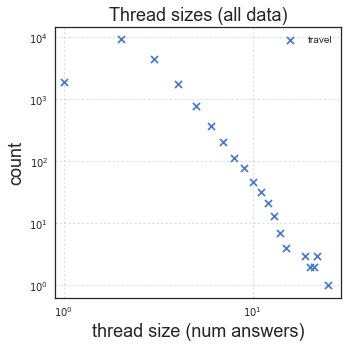

In [29]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

ax1.scatter(x=t_length_count[db]['t_sizes'], 
            y=t_length_count[db]['t_count'], 
            label=db, s=50, c='b', marker='x', clip_on=False)

ax1.set_xscale('log', nonposx='clip')
ax1.set_yscale('log', nonposy='clip')
plt.xlabel('thread size (num answers)', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.title('Thread sizes (all data)', fontsize=18)
ax1.set_xlim(xmin=0.9)
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend()
plt.tight_layout()
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'thread_sizes_ALL' + plot_format)